In [1]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.metrics import MeanIoU
from tt_augment.augment import generate_seg_augmenters

from keras.models import load_model
import torch
import segmentation_models as sm
from torch_scripts.torch_load_data import *

BACKBONE = 'mit_b3'
WEIGHTS = 'imagenet'
N_CLASSES = 6
PATCH_SIZE = 1024

MODEL_NAME = 'manet_mit_b3_imagenet_3b_6c_1024p_v2.pth'
MODEL_PATH = "../models/" + MODEL_NAME

PYTORCH = MODEL_NAME[-3:] == 'pth'
print(PYTORCH)

ModuleNotFoundError: No module named 'tt_augment'

In [35]:
TEST = False
if TEST: 
    IMAGE_PATH = '../data/CityofOttawa_Test_30cm.tif'
else: 
    IMAGE_PATH = '../data/images/base_cropped.tif'
image = cv2.imread(IMAGE_PATH) 


if PYTORCH: 
    preprocess_input = smp.encoders.get_preprocessing_fn(BACKBONE)
    image = preprocess_input(image)
    image = np.expand_dims(image, 0)
else: 
    preprocess_input = sm.get_preprocessing(BACKBONE)
    image = image.astype('float32') / 255
    image = preprocess_input(image)
    image = np.expand_dims(image, 0)

print(image.shape)

crop_dim = int(PATCH_SIZE / 2)
transformation_to_apply = [
    # {"name": "Mirror", "crop_to_dimension": (crop_dim, crop_dim)},
    # {"name": "CropScale", "crop_to_dimension": (crop_dim, crop_dim)},
    # {"name": "Rot", "angle": 45}, 
    # {"name": "NoAugment"}, 
    {"name": "FlipHorizontal"},
    {"name": "FlipVertical"}, 
]

_, h, w, _ = image.shape

tta = generate_seg_augmenters(
    image=image,
    window_size=(PATCH_SIZE, PATCH_SIZE),
    output_dimension=(1, h, w, N_CLASSES),
    transformation_to_apply=transformation_to_apply,
)

if PYTORCH: 
    model = torch.load(MODEL_PATH)
else:         
    model = load_model(MODEL_PATH, compile=False)

(1, 6667, 12493, 3)


In [36]:
for iterator, transformation in enumerate(tta):
    for augmented_fragment in transformation.transform_fragment():
        if PYTORCH: 
            augmented_fragment = torch.from_numpy(augmented_fragment.astype('float32')).permute(0, 3, 1, 2)
            augmented_fragment = augmented_fragment.to(device='cuda')
            # model.eval()
            prediction = model.predict(augmented_fragment)
            # print(prediction.shape)
            prediction = prediction.cpu().permute(0, 2, 3, 1).numpy()
            # print(prediction.shape)
        else: 
            prediction = model.predict(augmented_fragment)
        transformation.restore_fragment(prediction)
tta.merge()

In [37]:
output = tta.tta_output()
print(output.shape)
mask = np.argmax(output, axis=3)
print(mask.shape)
mask = np.squeeze(mask)
print(mask.shape)

(1, 6667, 12493, 6)
(1, 6667, 12493)
(6667, 12493)


In [38]:
if not TEST:
    true = cv2.imread("../data/masks/base_mask_cropped.tif", 0) 
    IOU_keras = MeanIoU(num_classes=N_CLASSES)  
    IOU_keras.update_state(mask, true)
    print("Mean IoU =", IOU_keras.result().numpy())

Mean IoU = 0.81566745


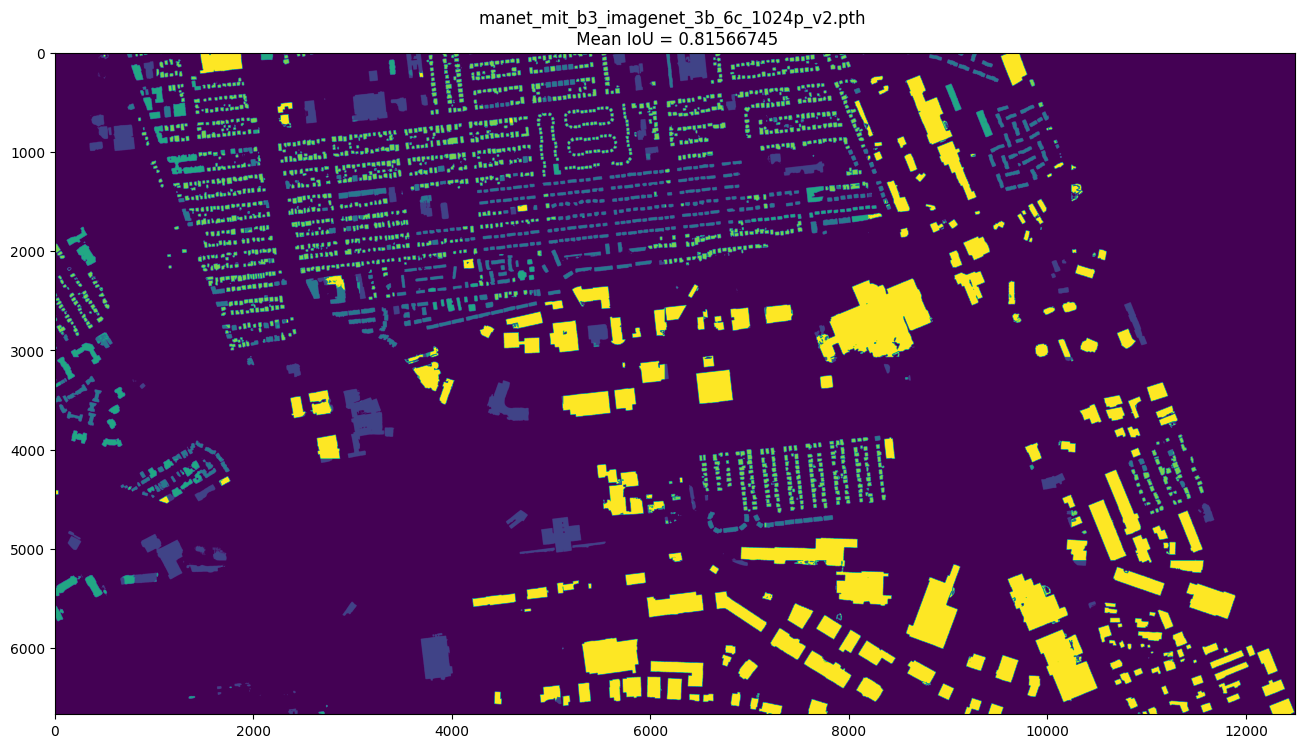

In [39]:
plt.figure(figsize=(16, 12))
if TEST: 
    plt.title(MODEL_NAME)
else: 
    plt.title(MODEL_NAME + " \n Mean IoU = " + str(IOU_keras.result().numpy()))
plt.imshow(mask)
plt.show()

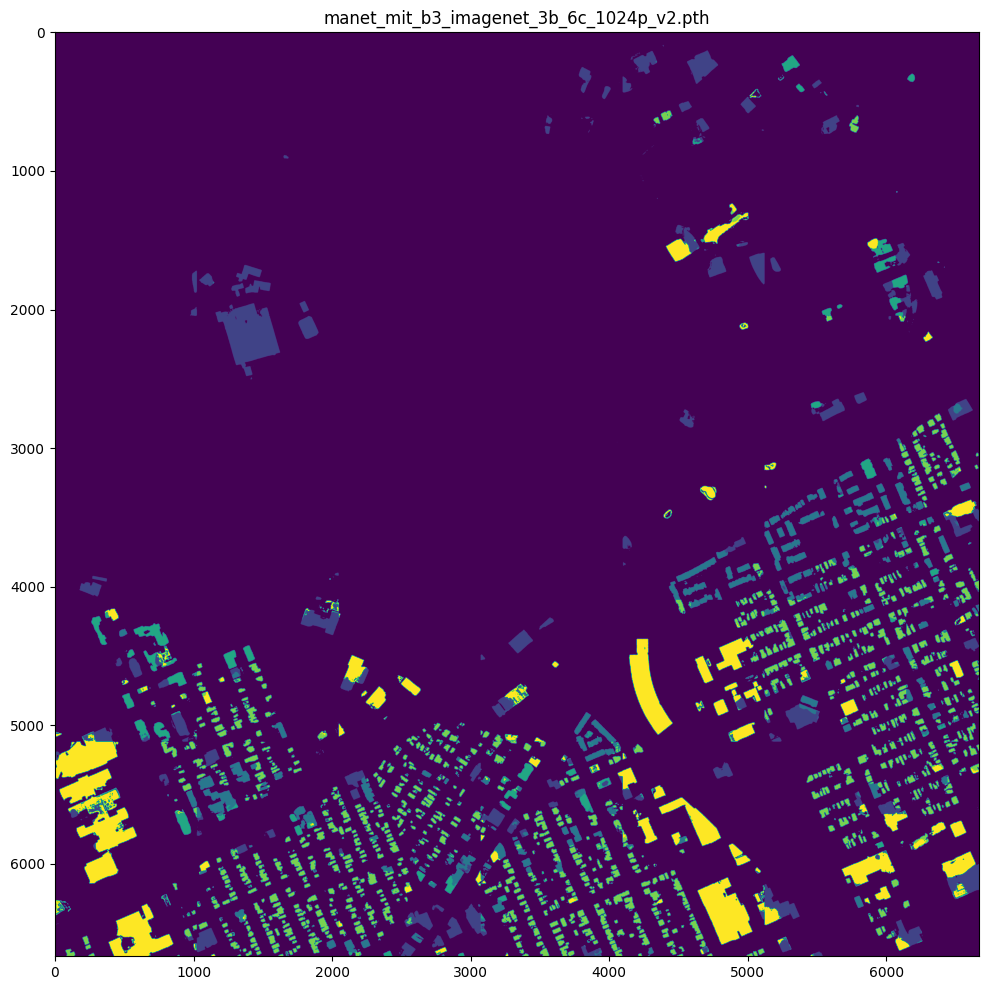

In [10]:
plt.figure(figsize=(16, 12))
if TEST: 
    plt.title(MODEL_NAME)
else: 
    plt.title(MODEL_NAME + " \n Mean IoU = " + str(IOU_keras.result().numpy()))
plt.imshow(mask)
plt.show()

---

### Save mask and mask overlaid on image

In [23]:
black = (0, 0, 0)
yellow = (255, 255, 000)
orange = (255, 150, 000) 
red = (255, 000, 000)
green = (000, 255, 000)
# pink = (255, 145, 200)
purple = (155, 55, 225) 
# blue = (000, 000, 255)
# white = (255, 255, 255)
# grey = (127, 127, 127)

segment_colors = [
    black,
    yellow, 
    orange, 
    red, 
    green, 
    # pink, 
    purple,
    # blue
    # grey,
]

In [24]:
img = cv2.imread(IMAGE_PATH)
new_mask = np.zeros((img.shape[0], img.shape[1], 3))

In [25]:
for i, color in enumerate(segment_colors):
    print(i, ' = ', color)
    new_mask[mask == i] = color[::-1]

0  =  (0, 0, 0)
1  =  (255, 255, 0)
2  =  (255, 150, 0)
3  =  (255, 0, 0)
4  =  (0, 255, 0)
5  =  (155, 55, 225)


In [26]:
img = img.astype('float32')
new_mask = new_mask.astype('float32')
alpha = float(.5)
pretty = cv2.addWeighted(img, alpha, new_mask, 1 - alpha, 0)

In [27]:
if TEST: 
    cv2.imwrite('../results/test_mask_result_' + MODEL_NAME[:-4] + '.png', mask)
    cv2.imwrite('../results/test_pretty_result_' + MODEL_NAME[:-4] + '.png', pretty)
else: 
    cv2.imwrite('../results/mask_result_' + MODEL_NAME[:-4] + '.png', mask)
    cv2.imwrite('../results/pretty_result_' + MODEL_NAME[:-4] + '.png', pretty)